# **Using a GAN to create malicious domains**
Just as machine-learning algorithms can be used to identify malicious domains, they can also be used to create domains that incorrectly-pass those checks. A popular method to generate such domains is using a Generative-Adversarial Network, otherwise known as a GAN.

## **How does a GAN work?**
A GAN is comprised of two models - a generator and a discriminator. These two models are pitted against each other. The generator tries to fool the discriminator by generating false input, and the discriminator tries to correctly identify the generator's false input mixed among correct ones.

![Image showing GAN network diagram](https://skymind.ai/images/wiki/gan_schema.png)
Credit: https://skymind.ai/images/wiki/gan_schema.png

A noise vector (vector of random numbers) is passed into the generator, which uses the noise to generate an output. That output is combined with actual output from a dataset and shuffled then passed to the discriminator. The discriminator predicts where the images came from - the generator or the true dataset.

## **Examples of GANs being used**
GANs have been used to create photorealistic images, cartoons, and more. Some examples:
![alt text](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/06/Example-of-Translation-from-Paintings-to-Photographs-with-CycleGAN.png)
https://junyanz.github.io/CycleGAN/

![alt text](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/06/Example-of-Textual-Descriptions-and-GAN-Generated-Photographs-if-Birds-and-Flowers.png)
[Generative Adversarial Text to Image Synthesis](https://arxiv.org/abs/1605.05396)

## Using GANs on Domains
We use Amazon's "Top 1 Million Sites" dataset for the domains of 1 million legitimate sites. This serves as the legitimate domains that the discriminator would have to distinguish from the fake domains generated by the generator.

First, we import the necessary libraries. Pandas and scikit-learn (sklearn) are used to perform preprocessing on the top 1-million-sites CSV. Keras is used to create and train the generator.

In [0]:
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.utils import shuffle

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model, load_model, clone_model
from keras.preprocessing import sequence
from keras.layers import Embedding, Dense, Conv1D, Input, GlobalMaxPooling1D, LSTM, Concatenate, TimeDistributed, MaxPooling1D, BatchNormalization, Reshape, Permute, Lambda
from keras.backend import int_shape, concatenate, transpose, permute_dimensions, expand_dims
from keras.utils import to_categorical
from keras.layers import RepeatVector, Activation

In [0]:
csv_file = pd.read_csv('top-1m.csv')
csv_file.columns = ["id","domain"] #this line is somehow removing "google.com" which is the first line so add it back
domains = [d.split('.')[0] for d in csv_file['domain']][:50000] #remove tld

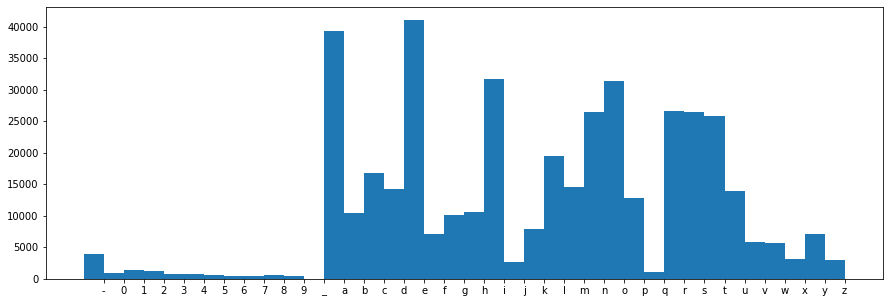

In [18]:
c = Counter("".join(domains))
keys, values = zip(*sorted(c.items()))

indexes = np.arange(len(keys))
width = 1

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, keys)
plt.show()

## Machine learning algorithms cannot process text directly
Using the ASCII codes of characters does not properly represent the distinction between characters.


```
1 = 'a', 25 = 'y'. 1 + 2 = 3? 'ay'?
```
A better example might be this: let's represent an apple as 1, and a banana as 2. If we perform any mathematical operations, what is the result? Perhaps 1 + 2 = smoothie?

Since machine-learning algorithms typically depend on having numbers as input to perform their mathematical operations, this poses an issue. One of the ways to circumvent this is to convert the categories to different columns of boolean value.

For example:


```
Table:
| 'Letter' |        |    'a'   |    'b'   |    'c'   |
------------        |--------------------------------|
|    'a'   | =====> |     1    |     0    |     0    |
|    'b'   |        |     0    |     1    |     0    |
|    'c'   |        |     0    |     0    |     1    |

```

This converts the categorical column to several categories indicating whether that certain value exists. This better-represents the column when used for mathematical operations. This procedure is typically known as one-hot-encoding.

To perform this for the domains, we use Keras's preprocessing module Tokenizer. It converts the alphabet provided into tokens, which is put through the tokenizer to convert the domain into a 2D array where the rows are the letter indices for the domain and the columns are which token is the letter.

In [0]:
tk = Tokenizer(num_words=None, char_level=True, oov_token=None)
alphabet = "abcdefghijklmnopqrstuvwxyz0123456789-_ "#,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
char_dict = {}
for i, char in enumerate(alphabet):
    char_dict[char] = i
tk.word_index = char_dict.copy()
vocab_size=len(tk.word_index)

In [20]:
tk.texts_to_sequences(domains[0]) # --> prints out sequence for "youtube"

[[24], [14], [20], [19], [20], [1], [4]]

In [0]:
def get_categorical(domain_sequence):
    m,n = domain_sequence.shape
    out = np.zeros((m,n,vocab_size))
    for i, seq in enumerate(domain_sequence):
        #one_sample = np.zeros((len(seq), len(alphabet)))
        for j, value in enumerate(seq):
            out[i][j][value] = 1
        #out.append(one_sample)
    return out

Tokenization requires a set-length input, since it needs to know how many letters exist to create the 2D array. We concatenate all the 2D arrays generated by putting domains into the tokenizer to get a 3D array, where each layer is a domain tokenized.

In [0]:
max_len = 15#max([len(i) for i in domains]) #we have to cap the  length of domain to an arbitrary number, pad all the domains having lesser than 15 chars
domain_sequence = tk.texts_to_sequences(domains)
padded_sequence = sequence.pad_sequences(domain_sequence, maxlen=max_len, value=vocab_size-1)
train_data = get_categorical(padded_sequence)

The input domains are separated into training (for training the model) and testing (for calculating how good our model is). We used 80% of the dataset set for training and 20% set for testing.

In [0]:
cut_off = int(len(train_data)*0.8)
np.random.shuffle(train_data)
X_train, X_test = train_data[:cut_off] , train_data[cut_off:]

## Creating the GAN
If we just put in the tokenized domain into a GAN and expected it to easily generate fake tokenized domains with a good discriminator, we would find that the training would be highly-inefficient. This is because domains are maximum length 65. With 39 possible characters in each index in a domain, that would result in **65 * 39 = 2535 inputs per domain!** Also, domains are different lengths. This is hard for a GAN that needs a set number of inputs to deal with.

To make this smaller, we use an _autoencoder_. It turns out that it is often possible to compress an array of numbers into a smaller-size array while still maintaining most of the important features of the array. This array of features is less-susceptible to being affected by different input lengths. Autoencoders perform this by having a "bottleneck" in the model.

![Autoencoder diagram](https://upload.wikimedia.org/wikipedia/commons/thumb/2/28/Autoencoder_structure.png/350px-Autoencoder_structure.png)

An autoencoder consists of two parts - an encoder and a decoder. The encoder converts the input (X) to a smaller array of features (z). The decoder performs the reverse - it takes the smaller array and tries to recreate the input (X').

Our autoencoder consists of an LSTM (encoder) to RepeatVector (repeats the input to LSTM to gather full sequence information) to LSTM and a Dense (decoder). The encoder returns a LSTM output of size 256, which is the compressed version of our input domain.

In [24]:
main_input = Input(shape=(None, vocab_size), name='main_input')
lstm = LSTM(units=256, return_sequences=False)(main_input)
encoder = Model(inputs=[main_input], outputs=[lstm])

r = RepeatVector(max_len)(lstm)
lstm2 = LSTM(units=256, return_sequences=True)(r)
decoder_output =  Dense(vocab_size, activation='softmax')(lstm2)
autoencoder = Model(inputs=[main_input], outputs=[decoder_output])
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, None, 39)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               303104    
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 15, 256)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 15, 256)           525312    
_________________________________________________________________
dense_2 (Dense)              (None, 15, 39)            10023     
Total params: 838,439
Trainable params: 838,439
Non-trainable params: 0
_________________________________________________________________


## Training an autoencoder
An autoencoder is trained by passing in an input and expecting the same as output (for a successful encoder and decoder). Here, we pass in our training domains and look for similar domains as output. We also save the model so that we do not need to repeat training every time our code is run.

In [25]:
autoencoder.compile(optimizer='adam', loss='categorical_crossentropy')
autoencoder.fit(X_train, X_train, epochs=20, batch_size=256, shuffle=True, validation_data=(X_test, X_test))
autoencoder.save('ais-csg.h5')

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 94s 2ms/step - loss: 1.9311 - val_loss: 1.6769
Epoch 2/20
40000/40000 [==============================] - 91s 2ms/step - loss: 1.5199 - val_loss: 1.3317
Epoch 3/20
40000/40000 [==============================] - 91s 2ms/step - loss: 1.2736 - val_loss: 1.2068
Epoch 4/20
40000/40000 [==============================] - 91s 2ms/step - loss: 1.0853 - val_loss: 1.0079
Epoch 5/20
40000/40000 [==============================] - 90s 2ms/step - loss: 0.9136 - val_loss: 0.8707
Epoch 6/20
40000/40000 [==============================] - 89s 2ms/step - loss: 0.8400 - val_loss: 0.7430
Epoch 7/20
40000/40000 [==============================] - 90s 2ms/step - loss: 0.6976 - val_loss: 0.6899
Epoch 8/20
40000/40000 [==============================] - 90s 2ms/step - loss: 0.5854 - val_loss: 0.5562
Epoch 9/20
40000/40000 [==============================] - 89s 2ms/step - loss: 0.5430 - val_loss: 0.4753
Epoch

In [0]:
autoencoder = load_model('ais-csg.h5')

Comparing the output of the autoencoder with its input, we see that they are extremely similar. Looks like the autoencoder successfully converts the 15 * 39 size array to a 256-size array.

In [27]:
test_data = X_test[20:30]
predictions = autoencoder.predict(test_data)
for i, pred in enumerate(predictions):
    domain, pred_domain = "", ""
    for j,row in enumerate(pred):
        char, pred_char = alphabet[np.argmax(test_data[i][j])], alphabet[np.argmax(row)]
        if char != " ":
            domain+=char
        if pred_char != " ":
            pred_domain+=pred_char
    print(domain, " ", pred_domain)

lullabot   lullabot
alnilin   alnilin
guc   guc
autooverload   autooverlaad
shibang   shibang
walmart   walmart
hentai   hentai
tuwien   tuwien
greenfunding   greenfunding
animeflv   animeflv


With a trained autoencoder, we freeze it so that it can be inserted into the GAN without being trained along with it.

In [0]:
for layer in autoencoder.layers:
    layer.trainable = False

## Creating the GAN Generator and Discriminator
As stated before, a GAN is comprised otwo parts - a generator and a discriminator. We have our generator use the decoder to take the "compressed" output of the generator's output to actual domain name. The generator converts the input to what is best to fool the discriminator by using a Dense layer before passing it to the decoder.

The discriminator does the opposite - it uses the encoder to create an easier-to-understand input from the domain which it then evaluates.

In [0]:
#generator is made from decoder
generator = Sequential()
generator.add(Dense(256, trainable=True, activation='relu'))
generator.add(autoencoder.layers[-3])
generator.add(autoencoder.layers[-2])
generator.add(autoencoder.layers[-1])

In [0]:
discriminator = Sequential()
discriminator.add(autoencoder.layers[1])
discriminator.add(Dense(256, trainable=True, activation='relu'))
discriminator.add(Dense(1, trainable=True, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='Adam')

In [0]:
for layer in generator.layers:
    print(layer.trainable)

for layer in discriminator.layers:
    print(layer.trainable)

True
False
False
False
False
True


Combining the discriminator and the generator creates the GAN.

In [0]:
gan_input = Input(shape=(20, ))
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer='Adam')
gan.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 20)                0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 15, 39)            540711    
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 303361    
Total params: 844,072
Trainable params: 5,633
Non-trainable params: 838,439
_________________________________________________________________


Some helper functions we made. generate\_samples() returns random domains. show_samples() prints out samples generated by generator while training.

In [0]:
def generate_samples(input=None):
    noise_samples = np.random.rand(10, 20)
    generated_domains = generator.predict_on_batch(noise_samples)
    domains = []
    for i, pred in enumerate(generated_domains):
        domain = ""
        for j,row in enumerate(pred):
            char = alphabet[np.argmax(row)]
            if char != " ":
                domain+=char
        domains.append(domain)
    return domains

In [0]:
def show_samples():
  noise_samples = np.random.rand(10, 20)
  generated_domains = generator.predict_on_batch(noise_samples)
  for i, pred in enumerate(generated_domains):
    domain = ""
    for j,row in enumerate(pred):
      char = alphabet[np.argmax(row)]
      if char != "":
        domain+=char
    print(domain)

## The issue with GANs
GANs are incredibly-powerful but come with a large issue - mode collapse. This occurs when either the generator or the discriminator learns better than the other, which results in the other model constantly being outdone and tries random actions to overcome the gap (which do not work).

When we first tried to train the GAN, we discovered that the generator always outperformed the discriminator by far. So we tried to improve this by giving the discriminator a head-start with extra training at the beginning.

In [0]:
for i in range(500):
  output = generator.predict(np.random.rand(100, 20))
  true = X_train[random.sample(range(0, len(X_train)), 100)]
  X = np.vstack((output, true))
  y = np.vstack((np.ones((100,1)), np.zeros((100,1))))
  loss = discriminator.train_on_batch(X,y)
  print("current loss for discriminator is ",loss)

current loss for discriminator is  0.7250443
current loss for discriminator is  0.7071254
current loss for discriminator is  0.68356586
current loss for discriminator is  0.670435
current loss for discriminator is  0.6570175
current loss for discriminator is  0.64975715
current loss for discriminator is  0.63670677
current loss for discriminator is  0.6175205
current loss for discriminator is  0.6008047
current loss for discriminator is  0.6078565
current loss for discriminator is  0.5818408
current loss for discriminator is  0.5834665
current loss for discriminator is  0.55868864
current loss for discriminator is  0.5478691
current loss for discriminator is  0.523493
current loss for discriminator is  0.5274741
current loss for discriminator is  0.5133457
current loss for discriminator is  0.50151014
current loss for discriminator is  0.5007356
current loss for discriminator is  0.47462067
current loss for discriminator is  0.47531727
current loss for discriminator is  0.46512854
curr

In [0]:
discriminator.trainable = False
for i in range(3):
    X = np.random.rand(100,20)
    y = np.zeros(100)
    loss = gan.train_on_batch(X,y)
    print("current loss for gan is ", loss)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


current loss for gan is  3.7333777


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


current loss for gan is  3.4141757
current loss for gan is  2.895833


Another method we used to reduce chances of mode collapse is to have a copy of the generator on the previous iteration put its results alongside the currently-best generator (which has had a few more more training cycles).

In [0]:
generator_copy = clone_model(generator)
generator_copy.set_weights(generator.get_weights())

## Training the GAN
Training a GAN involves several steps. For every iteration of training, the generator and the discriminator need to be trained - _but not at the same time_. This is because their loss functions depend on each other - a discriminator cannot judge how much better it has done than before if the generator is being changed during the run (and vice versa for the generator).

Instead, we train the discriminator with generated domains from the generator and real domains randomly-sampled from the dataset. Then, we freeze the discriminator and train the generator based on how good was the discriminator output. Repeating this, the GAN can be trained.

In [0]:
batch_size = 200
num_epochs = 100
num_batches = int(len(X_train)/batch_size)
count=1
for i in range(num_epochs):
    #for j in range(0, num_batches, batch_size):    
    for j in range(2):
        discriminator.trainable = True
        noise_recent_samples = generator.predict(np.random.rand(100, 20))
        noise_past_samples = generator_copy.predict(np.random.rand(100,20))
        real_samples = X_train[random.sample(range(0, len(X_train)), 200)]
        X = np.vstack((noise_recent_samples, noise_past_samples, real_samples))
        y = np.vstack((np.ones((200,1)), np.zeros((200,1))))
        X,y = shuffle(X,y)
        loss = discriminator.train_on_batch(X,y)
        print("current loss for discriminator is ",loss)
        
    if (count%10==0):
        generator_copy.set_weights(generator.get_weights())
        show_samples()
    
    for t in range(1):
        discriminator.trainable = False
        X = np.random.rand(100, 20)
        y = np.zeros(int(batch_size/2))
        loss = gan.train_on_batch(X,y)
        print("current loss for gan is ", loss)
    
    count+=1

current loss for discriminator is  1.1454034
current loss for discriminator is  1.1116277


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


current loss for gan is  0.31063884
current loss for discriminator is  1.0761762
current loss for discriminator is  1.0747486
current loss for gan is  0.34152016
current loss for discriminator is  1.077366
current loss for discriminator is  1.0588696
current loss for gan is  0.35138106
current loss for discriminator is  1.0268456
current loss for discriminator is  1.0186847
current loss for gan is  0.3827156
current loss for discriminator is  1.0005299
current loss for discriminator is  0.95332307
current loss for gan is  0.43116042
current loss for discriminator is  0.9408867
current loss for discriminator is  0.8886899
current loss for gan is  0.47254115
current loss for discriminator is  0.8997173
current loss for discriminator is  0.8607924
current loss for gan is  0.51074463
current loss for discriminator is  0.9070254
current loss for discriminator is  0.9037287
current loss for gan is  0.56196386
current loss for discriminator is  0.8875432
current loss for discriminator is  0.8

## Those generated domains don't seem to be very realistic . . .
You can see that generator's and discriminator's losses flip-flopped throughout the training - the generator would collapse then the discriminator would collapse. This indicates that the two models are relatively even, which is what we want.

Yet, we have obviously-fake output. This is where we run into the second issue for GANs - they are incredibly unstable. Many times, the same training would result in wildly-different outputs just because the random seed was different. This is the main issue holding GANs back. There have been papers applying GANs to domain-generating algorithms, which indicates that GANs can be used here. Yet, we could not replicate those results mostly due to the instability of GANs. In other words, GANs are extremely powerful yet extremely volatile at the same time.

There has been many research into techniques to make GANs more stable. For example, we could have used a pre-trained discriminator to train a generator against which would find a stable solution.